<a href="https://colab.research.google.com/github/mukaseevru/ds-school/blob/main/HW1/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%BE%D0%B5_%D0%94%D0%97_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style="text-align: center;"><b>Домашнее задание. Предобработка данных. Кластеризация при помощи kNN.
</b></h2>

Ссылка на дз в колаб: 
https://colab.research.google.com/drive/1bxkOBIWNySWmfTzCxwkYLE6lvu--anwh?usp=sharing

В этом домашнем задании нам нужно закрепить базовые понятия машинного обучения и научиться работать с простейшим метрическим алгоритмом кластеризации - kNN.

**Правила:**

- **Мягкий дедлайн:** 15 января 23:59. При отправке решения до этого момента вы можете исправить найденные ошибки без штрафа до жёсткого дедлайна.
- **Жёсткий дедлайн:** 22 января 23:59. Решения, отправленные позже, проверяться не будут, кроме случаев наличия уважительной причины.


Решения, размещенные на каких-либо интернет-ресурсах, не принимаются.
Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Пропущенные описания принимаемых аргументов дописать на русском. 

**ОБЯЗАТЕЛЬНО!**
При написании кода придерживайтесь `pep8` и используйте `type hints`.


**После жесткого дедлайна задания не принимаются.**

## Предсказание оттока телеком компании

#### Что такое "скорость оттока"?

Коэффициент оттока - это процент подписчиков на услугу, которые прекращают свою подписку на услугу в течение заданного периода времени. Для того чтобы компания могла расширить свою клиентуру, ее темпы роста, измеряемые числом новых клиентов, должны превышать темпы оттока. Этот показатель обычно выражается в процентах.

#### Почему отток так важен?

Отток клиентов - это термин, используемый в компаний с подписочной моделью ведения бизнеса, для описания потери клиентов. Например, если 10 из 100 подписчиков интернет-провайдера (ISP) отменили свои подписки, скорость оттока для этого провайдера составит 10%.

Отток важен, потому что он напрямую влияет на прибыльность вашего сервиса. Принято считать, что прибыльность услуги напрямую связана с ростом ее клиентской базы. Это может привести владельцев бизнеса к выводу, что для того, чтобы увеличить свою клиентскую базу, скорость приобретения новых клиентов должна превышать скорость оттока.

#### Что из себя представляет датасет?

Датасет представляет из себя 3333 записи из истории компании о клиентах с 20 колонками. Каждая колонка описывает клиента - его штат проживания, время использования услуги, номер, перечень подписок, время разговора, прочее.

#### В чем состоит ваше задание?

Ниже будет представлен конвейер (pipeline) обработки датасета с комментариями. На основе комментариев и результатов уже выполненых ячеек вам нужно будет восстановить код (на основе материалов занятий) по загрузке, обработке и построении модели наших данных. Желательно придерживаться в обработке результатов, которые вы уже увидите в ячейках.

------

## Загрузка данных

Загрузка данных может зависить от среды, где вы работаете. 

Если это гугл колаб - вам необходимо выполнить следующие комманды:

В первой вам необходимо перейти по ссылке, авторизироваться со своим аккаунтом, скопировать код из окна и вставить в поле выполнения ячейки.

Загружаем все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

Определение необходимых функций

In [2]:
# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='accuracy'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

Открываем склонированную папку

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/Sberbank_materials/master/telecom_churn.csv')

Отображаем данные

In [4]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


В случае, если вы работаете из среды анаконда - вам необходимо положить файл рядом с ноутбуком и выполнить:

```
df = pd.read_csv('./telecom_churn.csv')
```

 

## Работа с признаками

#### Визуальный анализ

Изучим наши данные, какие признаки исходного датасета никак не повлияют на результат прогноза? Выбросим такие столбцы и отобразим результат.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [6]:
df.drop(columns='phone number', inplace=True)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Посмотрим на описательную статистику, которая суммирует центральную тенденцию, дисперсию и форму распределения набора данных. Корректно ли все заполнено?

In [7]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Исследуем на наличие пропусков

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

Посмотрим на типы данных наших столбцов:

In [9]:
df.dtypes

state                      object
account length              int64
area code                   int64
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

Посмотрим как сбалансированны наши классы, можно распечатать или отобразить на грфике. Если не помните почему надо балансировать классы - [тык](https://www.coursera.org/lecture/supervised-learning/niesbalansirovannyie-dannyie-M97UX)

Можно увидеть, что данные несбалансированны.


False    2850
True      483
Name: churn, dtype: int64
Процент данных показывающих целевую группу "отток" 0.14


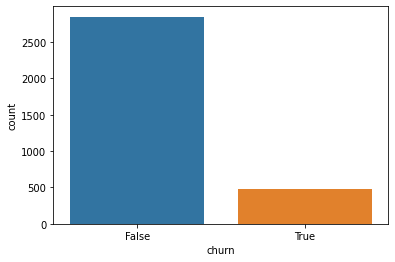

In [10]:
print(df.churn.value_counts())
print('Процент данных показывающих целевую группу "отток"', round(df.churn.value_counts()[1]/df.churn.count(), 2))
ax = sns.countplot(x='churn', data=df)

#### Работа с категориальными признаками

Если вы не понимаете логику за работой с котегориальными признаками - посмотрите [сюда](https://www.coursera.org/lecture/supervised-learning/rabota-s-katieghorial-nymi-priznakami-pqU2j), если же не знаете как это сделать в коде - [сюда](https://colab.research.google.com/drive/17UJ3zkE6dUL5UpQnLiaQp3f7BpV6iEss#scrollTo=_238K7-NQajf), пункт про категориальные признаки.

Посмотрим на те колонки, в которых тип данных object (строка) и перекодируем их, воспользуемся кодом с занятия.

In [11]:
encoded_data, encoders = number_encode_features(df) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Отобразим сами энкодеры

In [12]:
encoders

{'international plan': LabelEncoder(),
 'state': LabelEncoder(),
 'voice mail plan': LabelEncoder()}

Выделим целевую переменную в бинарный формат (в отдельную переменную)

In [13]:
y_full = np.array(encoded_data['churn'], dtype='int')
y_full

array([0, 0, 0, ..., 0, 0, 0])

Выделим целевую переменную в бинарный формат и выкинем ее из обучающей выборки.

In [14]:
print('Ответы\n', y_full)
print('Обучающая выборка')
encoded_data = encoded_data.drop('churn', axis=1)
encoded_data.head()

Ответы
 [0 0 0 ... 0 0 0]
Обучающая выборка


,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


Посмотрим на распределение величин по признакам в наших данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e464752b0>,
      dtype=object)

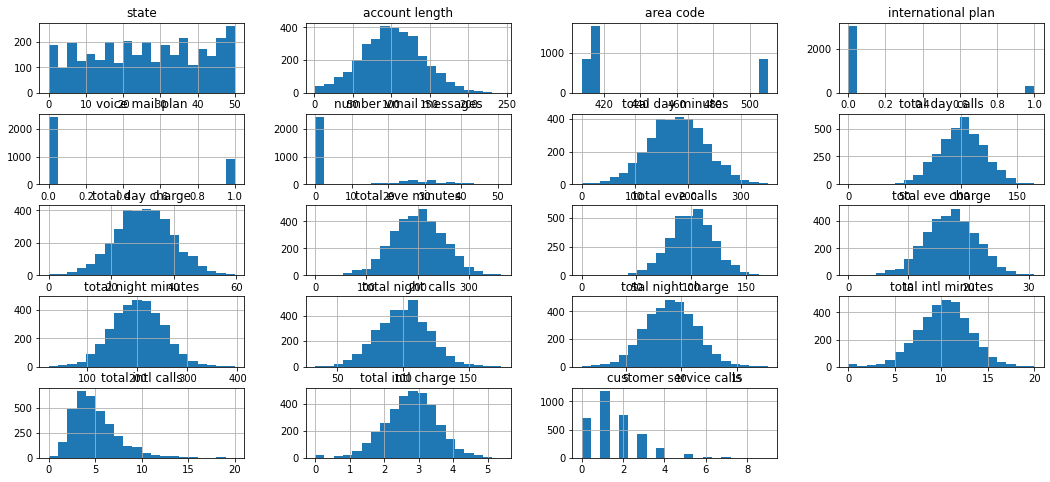

In [15]:
encoded_data.hist(figsize=(18, 8), layout=(5,4), bins=20)

Построим матрицу корреляций, выбросим данные с единичной линейной зависимостью - они (шум) просто повысят вычислительную сложность.

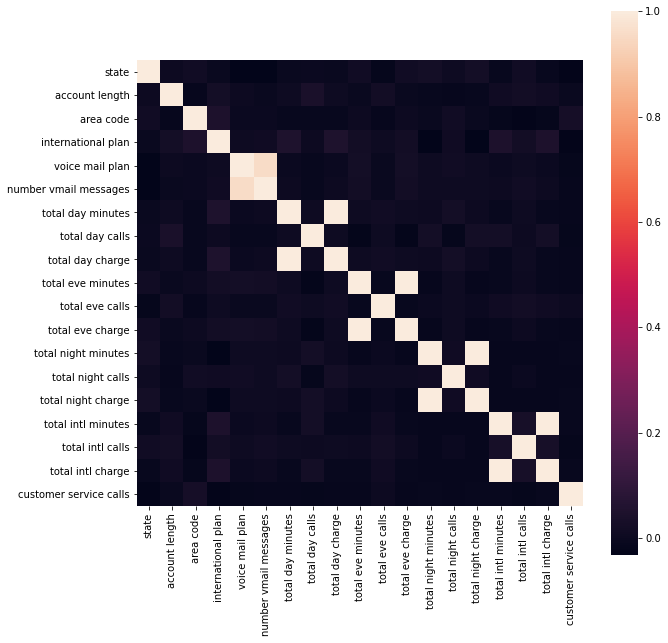

In [16]:
plt.subplots(figsize=(10,10))
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

In [17]:
encoded_data = encoded_data.drop(['total day charge', 'total eve charge', 'total night charge', 'total intl charge'], axis=1)
encoded_data.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
0,16,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1
1,35,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1
2,31,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0
3,35,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2
4,36,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3


## Работа с данными

Создадим обучающую выборку Х, переведем получанные цифровые данные в np.array

In [18]:
X_full = np.array(encoded_data)
X_full

array([[ 16. , 128. , 415. , ...,  10. ,   3. ,   1. ],
       [ 35. , 107. , 415. , ...,  13.7,   3. ,   1. ],
       [ 31. , 137. , 415. , ...,  12.2,   5. ,   0. ],
       ...,
       [ 39. ,  28. , 510. , ...,  14.1,   6. ,   2. ],
       [  6. , 184. , 510. , ...,   5. ,  10. ,   2. ],
       [ 42. ,  74. , 415. , ...,  13.7,   4. ,   0. ]])

Нормализуем наши данные. Если не помните зачем это делать? [тык](https://www.coursera.org/lecture/supervised-learning/masshtabirovaniie-priznakov-ozNT3)

In [19]:
X_scaled = scale(np.array(X_full, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[-0.6786493 ,  0.67648946, -0.52360328, ..., -0.08500823,
        -0.60119509, -0.42793202],
       [ 0.6031696 ,  0.14906505, -0.52360328, ...,  1.24048169,
        -0.60119509, -0.42793202],
       [ 0.33331299,  0.9025285 , -0.52360328, ...,  0.70312091,
         0.21153386, -1.1882185 ],
       ...,
       [ 0.87302621, -1.83505538,  1.71881732, ...,  1.3837779 ,
         0.61789834,  0.33235445],
       [-1.35329082,  2.08295458,  1.71881732, ..., -1.87621082,
         2.24335625,  0.33235445],
       [ 1.07541867, -0.67974475, -0.52360328, ...,  1.24048169,
        -0.19483061, -1.1882185 ]])

In [20]:
X_scaled.shape, y_full.shape

((3333, 15), (3333,))

Надо помнить, что наша выборка несбралансирована, так что надо будет провести ее балансировку, в ходе занятия было показано, что будет (у precision 0.18), если ее не проводить:

Найдем по y индексы клиентов, которые относятся к классу "не ушли"
и, перемешав выборку, обрежем ее до размеров "ушедших". Т.к. это на занятии не разбиралось - код прилагается.

Альтернативой выбрасыванию ценных данных - модифицировать шаг градиентного спуска для класса с несбалансированными данными.

Большинство алгоритмов sklearn имеют аргумент class_weight, который принимает на вход частоты каждого распознаваемого класса или считает их вытоматически, если указано 'balanced'

Пример из алгоримта SVM:

class_weight dict or ‘balanced’, default=None

Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

Использовать модифицированный шаг градиентного спуска предпочтительнее, если алгоритм поддерживает его (в большинстве случаев так и есть). В качестве примера возможного варинта балансировки - убрать лишние данные. Ниже представлен код, который находит индексы в зависимости от метки класса и выбрасывает лишние.

In [21]:
# np.argwhere вернет индексы тех элементов массива y (целевой переменной), где значение 0
not_churn_ids = np.argwhere(y_full == 0).flatten()
print('Всего не ушедших', len(not_churn_ids))
not_churn_ids

Всего не ушедших 2850


array([   0,    1,    2, ..., 3330, 3331, 3332])

Перемешаем массив с выбранным random state (чтоб в дальнейшем у нас совпадали выборки) выберем в нем "лишние" id тех, кто остались (кто портит нам прогноз алгоритма). Кол-во "лишних" = кол-во оставшихся - кол-во ушедшых.

In [22]:
not_churn_ids = shuffle(not_churn_ids, random_state = 42)
# найдем "лишних", для этого обрежем найденные id на кол-во ушедших (внутри len)
not_churn_ids = not_churn_ids[len(np.argwhere(y_full == 1).flatten()):]
print(len(not_churn_ids))
# отображаем кол-во и сами id, которые мы должны выкинуть
not_churn_ids

2367


array([ 877, 3298,  614, ..., 1291, 1482,  989])

Проверим, сбалансированны ли классы

по идее (оставшиеся) - ("лишние") = (ушедшие)

In [23]:
len(np.argwhere(y_full == 0).flatten()) - len(not_churn_ids) == len(np.argwhere(y_full == 1).flatten())

True

Теперь можно выкинуть "лишние" id из X и y

In [24]:
# np.delete принимает массив, индексы, которые выбросить и по какой оси выкидывать
X = np.delete(X_full, not_churn_ids, 0)
X_scaled = np.delete(X_scaled, not_churn_ids, 0)
y = np.delete(y_full, not_churn_ids, 0)

In [25]:
# отобразим итоговый размер признаков датасета
X.shape, X_scaled.shape, y.shape

((966, 15), (966, 15), (966,))

Теперь видим, что классы сбалансированы.

In [26]:
pd.Series(y).value_counts()

1    483
0    483
dtype: int64

## Создание алгоритмов

Посмотрим на 2 типа алгоритмов, которые мы прошли - KNN и линейную модель. В случае KNN будем решать задачу классификации. В случае линейного классификатора, для демонстрации всей обработки, будем использовать регрессию.

Разделим нашу выборку на test train в соотношении 85 на 15 %

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#### KNN

Построим сетку, по аналогии с занятием 6, для перебора гиперпараметра для нахождения лучшего гиперпараметра KNN, пройдем 100 значений (от 1 до 100)

In [28]:
knn = KNeighborsClassifier()
# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype='int'),#}
            'p': np.array(np.linspace(1, 5, 5), dtype='int')}

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, knn_grid, scoring='accuracy', cv=10)

# Обучаем его
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96

Строим график зависимости качества от числа соседей

подсказка: результаты обучения хранятся в атрибуте cv_results_ объекта gs (grid search из библиотеки sklearn)

{'n_neighbors': 60, 'p': 1} 0.687026153394064


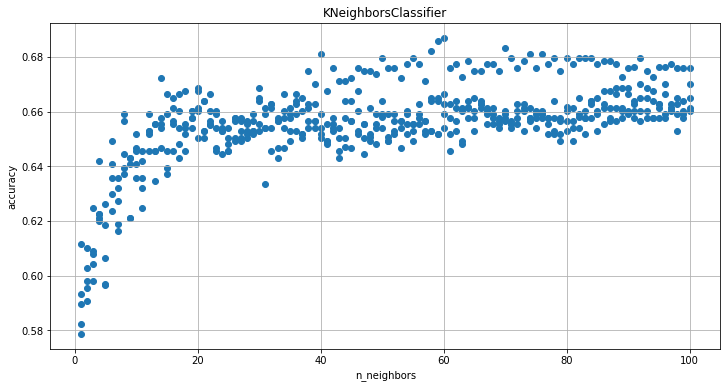

In [29]:
print(gs.best_params_, gs.best_score_)
grid_plot(gs.cv_results_['param_n_neighbors'].data,
          gs.cv_results_['mean_test_score'],
          'n_neighbors',
          'KNeighborsClassifier')

In [30]:
# С нормализованными данными
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

knn = KNeighborsClassifier()
# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype='int'),
            'p': np.array(np.linspace(1, 5, 5), dtype='int'),
            'metric': ['minkowski','euclidean','manhattan'],
            'weights': ['uniform','distance']}

# Создаем объект кросс-валидации
gs_sc = GridSearchCV(knn, knn_grid, scoring='accuracy', cv=10)

# Обучаем его
gs_sc.fit(X_train_sc, y_train_sc)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  2...
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85

{'metric': 'minkowski', 'n_neighbors': 29, 'p': 1, 'weights': 'distance'} 0.8282985600940347


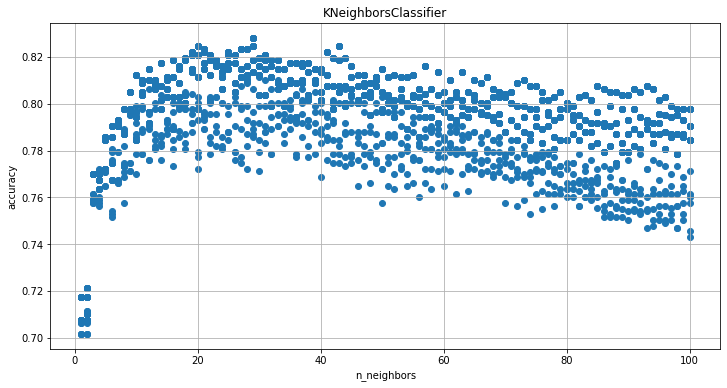

In [31]:
print(gs_sc.best_params_, gs_sc.best_score_)
grid_plot(gs_sc.cv_results_['param_n_neighbors'].data,
          gs_sc.cv_results_['mean_test_score'],
          'n_neighbors',
          'KNeighborsClassifier')

Отобразим лучший параметр (y gs есть атрибуты best_param, best_score)

In [32]:
gs.best_params_, gs.best_score_

({'n_neighbors': 60, 'p': 1}, 0.687026153394064)

In [33]:
gs_sc.best_params_, gs_sc.best_score_

({'metric': 'minkowski', 'n_neighbors': 29, 'p': 1, 'weights': 'distance'},
 0.8282985600940347)

Инициализируем отдельный классификатор с лучшим значением, найденным из предыдущего перебора

In [34]:
knn = KNeighborsClassifier(n_neighbors=gs_sc.best_params_['n_neighbors'],
                           p=gs_sc.best_params_['p'])
clf_knn_sc = knn.fit(X_train_sc, y_train_sc)

Получим предсказания от классификатора

In [35]:
# получаем от них предикты
y_knn = clf_knn_sc.predict(X_test_sc)

Посмотрим на метрики качества через classification report

In [36]:
print(metrics.classification_report(y_test_sc, y_knn))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        73
           1       0.90      0.75      0.82        72

    accuracy                           0.83       145
   macro avg       0.84      0.83      0.83       145
weighted avg       0.84      0.83      0.83       145



[[67  6]
 [18 54]]


Text(0.5, 42.0, 'Predicted value')

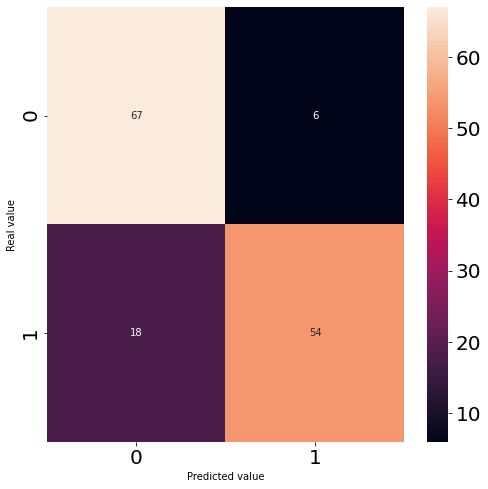

In [37]:
fig = plt.figure(figsize=(8,8))
nn_mtx = metrics.confusion_matrix(y_test_sc, y_knn)
print(nn_mtx)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

ROC AUC = 0.8339


Text(0.5, 0, 'False Positive Rate')

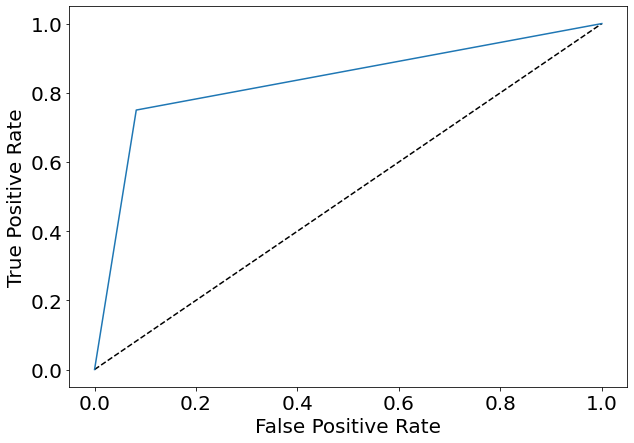

In [38]:
fpr, tpr, _ = metrics.roc_curve(y_test_sc, y_knn)
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

#### Логистическая регрессия

Здесь Вам нужно применить логистическую регрессию, по аналогии с занятием (10 лекция) и оценить результат по $R^2$ и MAE.
Теперь без подсказок

In [39]:
# Зададим сетку - среди каких значений выбирать наилучший параметр.
param_grid = {'C':list(range(1, 10)),
              'penalty': ['l1', 'l2']}

# Создаем объект кросс-валидации
gs = GridSearchCV(LogisticRegression(random_state=42),
                  param_grid,
                  cv=10,
                  # scoring='r2')
                  # scoring='neg_mean_absolute_error')
                  scoring=['r2', 'neg_mean_absolute_error'],
                  refit=False)

# Обучаем его
gs.fit(X_train_sc, y_train_sc)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['r2', 'neg_mean_absolute_error'], verbose=0)

In [40]:
# gs.best_params_, gs.best_score_

In [41]:
gs.cv_results_['mean_test_r2']

array([       nan, 0.0402439 ,        nan, 0.05      ,        nan,
       0.05      ,        nan, 0.05      ,        nan, 0.05      ,
              nan, 0.05      ,        nan, 0.04512195,        nan,
       0.04512195,        nan, 0.04512195])

In [42]:
gs.cv_results_['params']

[{'C': 1, 'penalty': 'l1'},
 {'C': 1, 'penalty': 'l2'},
 {'C': 2, 'penalty': 'l1'},
 {'C': 2, 'penalty': 'l2'},
 {'C': 3, 'penalty': 'l1'},
 {'C': 3, 'penalty': 'l2'},
 {'C': 4, 'penalty': 'l1'},
 {'C': 4, 'penalty': 'l2'},
 {'C': 5, 'penalty': 'l1'},
 {'C': 5, 'penalty': 'l2'},
 {'C': 6, 'penalty': 'l1'},
 {'C': 6, 'penalty': 'l2'},
 {'C': 7, 'penalty': 'l1'},
 {'C': 7, 'penalty': 'l2'},
 {'C': 8, 'penalty': 'l1'},
 {'C': 8, 'penalty': 'l2'},
 {'C': 9, 'penalty': 'l1'},
 {'C': 9, 'penalty': 'l2'}]

In [43]:
list(zip(gs.cv_results_['mean_test_r2'],
         gs.cv_results_['mean_test_neg_mean_absolute_error'],
         gs.cv_results_['params']))

[(nan, nan, {'C': 1, 'penalty': 'l1'}),
 (0.04024390243902439, -0.23993535116074055, {'C': 1, 'penalty': 'l2'}),
 (nan, nan, {'C': 2, 'penalty': 'l1'}),
 (0.04999999999999999, -0.23749632677049667, {'C': 2, 'penalty': 'l2'}),
 (nan, nan, {'C': 3, 'penalty': 'l1'}),
 (0.04999999999999999, -0.23749632677049667, {'C': 3, 'penalty': 'l2'}),
 (nan, nan, {'C': 4, 'penalty': 'l1'}),
 (0.04999999999999999, -0.23749632677049667, {'C': 4, 'penalty': 'l2'}),
 (nan, nan, {'C': 5, 'penalty': 'l1'}),
 (0.04999999999999999, -0.23749632677049667, {'C': 5, 'penalty': 'l2'}),
 (nan, nan, {'C': 6, 'penalty': 'l1'}),
 (0.04999999999999999, -0.23749632677049667, {'C': 6, 'penalty': 'l2'}),
 (nan, nan, {'C': 7, 'penalty': 'l1'}),
 (0.04512195121951218, -0.2387158389656186, {'C': 7, 'penalty': 'l2'}),
 (nan, nan, {'C': 8, 'penalty': 'l1'}),
 (0.04512195121951218, -0.2387158389656186, {'C': 8, 'penalty': 'l2'}),
 (nan, nan, {'C': 9, 'penalty': 'l1'}),
 (0.04512195121951218, -0.2387158389656186, {'C': 9, 'pena

In [44]:
lg = LogisticRegression(C=2,
                        penalty='l2')
lg.fit(X_train_sc, y_train_sc)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
y_lg = lg.predict(X_test_sc)

In [46]:
metrics.r2_score(y_test_sc, y_lg)

-0.1035007610350076

In [47]:
metrics.median_absolute_error(y_test_sc, y_lg)

0.0

In [48]:
X_train_sc

array([[-0.88104175,  2.30899361, -0.52360328, ...,  0.23740824,
         0.21153386,  0.33235445],
       [-1.15089836,  0.72672036, -0.52360328, ...,  0.77476902,
        -1.00755957, -0.42793202],
       [-0.47625684, -0.7550911 ,  1.71881732, ..., -0.04918418,
         0.21153386,  1.09264093],
       ...,
       [ 0.73809791, -0.05185854, -0.68883427, ..., -0.83731332,
        -1.41392404,  1.09264093],
       [-1.48821913,  0.04860325, -0.52360328, ...,  0.45235255,
         1.02426282, -1.1882185 ],
       [ 0.40077714,  0.52579677, -0.68883427, ..., -0.62236901,
        -1.00755957,  0.33235445]])

Попробуем на несбалансированных данных и добавим class_weight='balanced'

In [49]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(scale(np.array(X_full, dtype='float'), with_std=True, with_mean=True), y_full, test_size=0.15, random_state=42)

# Зададим сетку - среди каких значений выбирать наилучший параметр.
param_grid = {'C': list(np.linspace(0.1, 1, 10)),
              'penalty': ['l1', 'l2']}

# Создаем объект кросс-валидации
gs = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                  param_grid,
                  cv=10,
                  # scoring='r2')
                  # scoring='neg_mean_absolute_error')
                  scoring=['r2', 'neg_mean_absolute_error'],
                  refit=False)

# Обучаем его
gs.fit(X_train_f, y_train_f)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9, 1.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['r2', 'neg_mean_absolute_error'], verbose=0)

In [50]:
gs.cv_results_['mean_test_r2']

array([        nan, -0.93760433,         nan, -0.91455095,         nan,
       -0.9117004 ,         nan, -0.91752345,         nan, -0.91752345,
               nan, -0.91752345,         nan, -0.91752345,         nan,
       -0.91752345,         nan, -0.9203757 ,         nan, -0.9203757 ])

In [51]:
gs.cv_results_['params']

[{'C': 0.1, 'penalty': 'l1'},
 {'C': 0.1, 'penalty': 'l2'},
 {'C': 0.2, 'penalty': 'l1'},
 {'C': 0.2, 'penalty': 'l2'},
 {'C': 0.30000000000000004, 'penalty': 'l1'},
 {'C': 0.30000000000000004, 'penalty': 'l2'},
 {'C': 0.4, 'penalty': 'l1'},
 {'C': 0.4, 'penalty': 'l2'},
 {'C': 0.5, 'penalty': 'l1'},
 {'C': 0.5, 'penalty': 'l2'},
 {'C': 0.6, 'penalty': 'l1'},
 {'C': 0.6, 'penalty': 'l2'},
 {'C': 0.7000000000000001, 'penalty': 'l1'},
 {'C': 0.7000000000000001, 'penalty': 'l2'},
 {'C': 0.8, 'penalty': 'l1'},
 {'C': 0.8, 'penalty': 'l2'},
 {'C': 0.9, 'penalty': 'l1'},
 {'C': 0.9, 'penalty': 'l2'},
 {'C': 1.0, 'penalty': 'l1'},
 {'C': 1.0, 'penalty': 'l2'}]

In [52]:
list(zip(gs.cv_results_['mean_test_r2'],
         gs.cv_results_['mean_test_neg_mean_absolute_error'],
         gs.cv_results_['params']))

[(nan, nan, {'C': 0.1, 'penalty': 'l1'}),
 (-0.937604330236752, -0.2372169412233116, {'C': 0.1, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.2, 'penalty': 'l1'}),
 (-0.9145509500855645, -0.2343913303140397, {'C': 0.2, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.30000000000000004, 'penalty': 'l1'}),
 (-0.9117004030615756,
  -0.23403921763798335,
  {'C': 0.30000000000000004, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.4, 'penalty': 'l1'}),
 (-0.9175234483290655, -0.23474593141890207, {'C': 0.4, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.5, 'penalty': 'l1'}),
 (-0.9175234483290655, -0.23474593141890207, {'C': 0.5, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.6, 'penalty': 'l1'}),
 (-0.9175234483290655, -0.23474593141890207, {'C': 0.6, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.7000000000000001, 'penalty': 'l1'}),
 (-0.9175234483290655,
  -0.23474593141890207,
  {'C': 0.7000000000000001, 'penalty': 'l2'}),
 (nan, nan, {'C': 0.8, 'penalty': 'l1'}),
 (-0.9175234483290655, -0.23474593141890207, {'C': 0.8, 'penalty': 'l2'}

In [53]:
lg = LogisticRegression(C=0.3,
                        penalty='l2')
lg.fit(X_train_sc, y_train_sc)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
y_lg = lg.predict(X_test_f)

In [55]:
metrics.r2_score(y_test_f, y_lg)

-0.6861100984323736

In [56]:
metrics.median_absolute_error(y_test_f, y_lg)

0.0